In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light28_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Mon Mar  8 02:57:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 71%   63C    P2   240W / 370W |  13561MiB / 24268MiB |     96%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 54%   

In [3]:
save_dir = 'save/light28_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json  save_0


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 0

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if False:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 32.5MiB
TTS size 26.2MiB
MelEncoder size 8.2MiB
MelDecoder size 16.0MiB
0
done


In [6]:
trainset = LJDataset(tts_hparams.root_dir)
collate_fn = TextMelCollate()
train_loader = torch.utils.data.DataLoader(trainset, num_workers=tts_hparams.num_workers, 
                          shuffle=True,
                          sampler=None,
                          batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)

print(train_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.02896873950958252


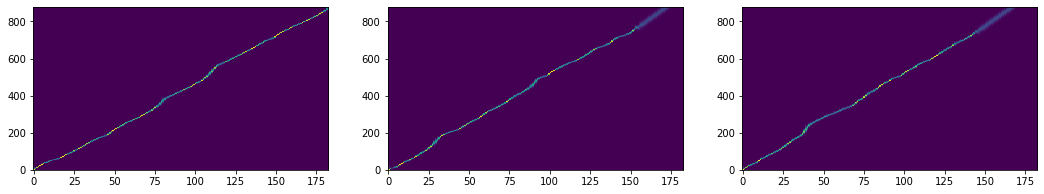

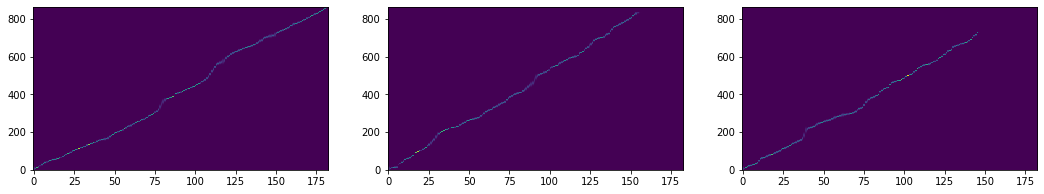

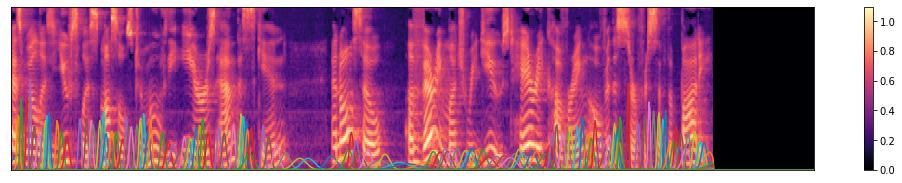

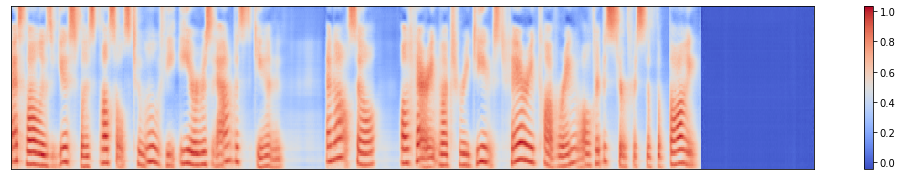

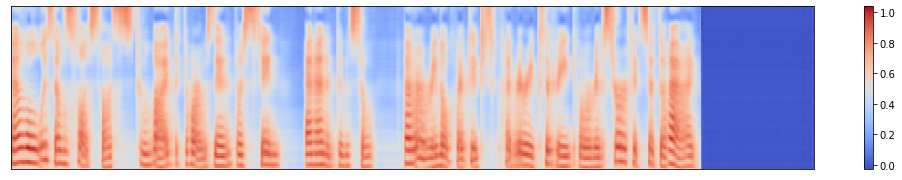

tensor(2.9171, device='cuda:0')
step : 7001 stt : 0.8533 tts : 0.1410 recon : 0.0028 kl : 0.0085 beta : 0.1401
tensor(4.2480, device='cuda:0')
step : 7002 stt : 0.8872 tts : 0.1282 recon : 0.0034 kl : 0.0092 beta : 0.1401
tensor(5.9938, device='cuda:0')
step : 7003 stt : 0.8523 tts : 0.1320 recon : 0.0033 kl : 0.0089 beta : 0.1401
tensor(2.9888, device='cuda:0')
step : 7004 stt : 0.8484 tts : 0.1470 recon : 0.0030 kl : 0.0085 beta : 0.1401
tensor(5.4004, device='cuda:0')
step : 7005 stt : 0.8446 tts : 0.1404 recon : 0.0029 kl : 0.0082 beta : 0.1401
tensor(5.4599, device='cuda:0')
step : 7006 stt : 0.7530 tts : 0.1333 recon : 0.0028 kl : 0.0082 beta : 0.1402
tensor(3.6295, device='cuda:0')
step : 7007 stt : 0.7428 tts : 0.1288 recon : 0.0027 kl : 0.0083 beta : 0.1402
tensor(2.2587, device='cuda:0')
step : 7008 stt : 0.8325 tts : 0.1403 recon : 0.0027 kl : 0.0082 beta : 0.1402
tensor(5.9962, device='cuda:0')
step : 7009 stt : 0.7701 tts : 0.1393 recon : 0.0026 kl : 0.0081 beta : 0.1402
t

tensor(2.6149, device='cuda:0')
step : 7075 stt : 0.7496 tts : 0.1219 recon : 0.0035 kl : 0.0082 beta : 0.1415
tensor(5.0266, device='cuda:0')
step : 7076 stt : 0.9023 tts : 0.1466 recon : 0.0043 kl : 0.0091 beta : 0.1416
tensor(2.7761, device='cuda:0')
step : 7077 stt : 0.7148 tts : 0.1244 recon : 0.0031 kl : 0.0083 beta : 0.1416
tensor(10.6492, device='cuda:0')
step : 7078 stt : 0.7963 tts : 0.1253 recon : 0.0028 kl : 0.0082 beta : 0.1416


In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta.item())
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta.item())    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=0.7)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(_y[index])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(_s[index, :, :_y.shape[2]])
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [16]:
logger.save(step, model, optimizer)

saved save/light3_model/save_17108


torch.Size([1, 80, 848]) 0.02991509437561035
{'alignment': 0.0008552074432373047, 'random': 0.0006392002105712891, 'last_conv': 0.017547130584716797, 'z_proj': 0.0006856918334960938, 'cond': 0.0010941028594970703, 'up': 0.0013666152954101562, 'encode': 0.0046885013580322266, 'pad': 4.220008850097656e-05}


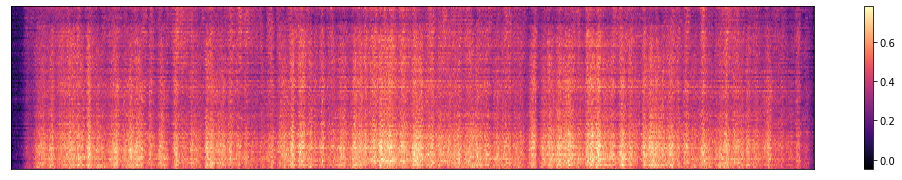

In [17]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for batch in train_loader:
    batch = to_cuda(batch)
    break
        
model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [18]:
time_sum = 0
for key in time_dict.keys():
    time_sum += time_dict[key]

for key in time_dict.keys():
    print(key, '%0.2f' % (time_dict[key] / time_sum))


alignment 0.03
random 0.02
last_conv 0.65
z_proj 0.03
cond 0.04
up 0.05
encode 0.17
pad 0.00
